# Bayesian Flows

Bayesian networks are similar to normal Linear models, where each weight is replaced by a learnable gaussian distribution. 

At each evaluation, a bayesian model performs a sampling of its weights values and returns a different result. 

During the training the average and std of the weights is learnts to reproduce the correct output distribution.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from sklearn.datasets import make_moons
from torch import nn

import zuko

In [2]:
adjacency = torch.randn(4, 3) < 0
adjacency

tensor([[ True,  True, False],
        [ True,  True, False],
        [False, False,  True],
        [False, False, False]])

In [3]:
net = zuko.nn.MaskedMLP(adjacency, [16, 32], activation=nn.ELU)
net

MaskedMLP(
  (0): MaskedLinear(in_features=3, out_features=16, bias=True)
  (1): ELU(alpha=1.0)
  (2): MaskedLinear(in_features=16, out_features=32, bias=True)
  (3): ELU(alpha=1.0)
  (4): MaskedLinear(in_features=32, out_features=4, bias=True)
)

In [4]:
x = torch.randn(3)
torch.autograd.functional.jacobian(net, x)

tensor([[-0.0816,  0.0492,  0.0000],
        [ 0.0980, -0.0117,  0.0000],
        [ 0.0000,  0.0000,  0.0571],
        [ 0.0000,  0.0000,  0.0000]])

A bayesian version of the MaskedMLP is also available.

In [5]:
bnet = zuko.nn.MaskedMLP(adjacency, [16, 32], activation=nn.ELU, bayesian=True)
bnet

MaskedMLP(
  (0): MaskedBayesianLinear(in_features=3, out_features=16, bias=True)
  (1): ELU(alpha=1.0)
  (2): MaskedBayesianLinear(in_features=16, out_features=32, bias=True)
  (3): ELU(alpha=1.0)
  (4): MaskedBayesianLinear(in_features=32, out_features=4, bias=True)
)

In [6]:
x = torch.randn(3)
torch.autograd.functional.jacobian(bnet, x)

tensor([[ 0.1800,  0.3202,  0.0000],
        [-0.0111,  0.2771,  0.0000],
        [ 0.0000,  0.0000,  0.0234],
        [ 0.0000,  0.0000,  0.0000]])

At each evaluation the weights of the bayesian MLP are sampled from their gaussian distribution, producing a different value.

In [7]:
for i in range(10):
    print(bnet(x))

tensor([-0.0279, -0.1135,  0.0086, -0.0001], grad_fn=<AddBackward0>)
tensor([-3.6410e-02, -1.1416e-01,  1.7735e-02, -8.4802e-05],
       grad_fn=<AddBackward0>)
tensor([-4.3932e-02, -1.2907e-01,  1.5034e-02, -2.3142e-05],
       grad_fn=<AddBackward0>)
tensor([-3.3545e-02, -1.1098e-01,  1.2666e-02, -3.8905e-05],
       grad_fn=<AddBackward0>)
tensor([-2.8225e-02, -1.3657e-01,  3.9106e-02, -5.3902e-05],
       grad_fn=<AddBackward0>)
tensor([-5.4924e-02, -1.4219e-01, -1.1883e-02, -5.2887e-05],
       grad_fn=<AddBackward0>)
tensor([-0.0302, -0.1092,  0.0018,  0.0002], grad_fn=<AddBackward0>)
tensor([-1.8868e-02, -1.2246e-01,  8.7368e-03, -6.1112e-05],
       grad_fn=<AddBackward0>)
tensor([-3.9488e-02, -1.2704e-01,  3.5444e-02,  1.2359e-04],
       grad_fn=<AddBackward0>)
tensor([-2.5728e-02, -1.1381e-01,  2.4041e-02,  2.0886e-05],
       grad_fn=<AddBackward0>)


## Creating Bayesian flows

In [8]:
model = zuko.flows.spline.NSF(
    features=3, context=5, bins=10, transforms=3, hidden_features=[64, 64], bayesian=True
)

model

NSF(
  (transform): LazyComposedTransform(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=10)
      (order): [0, 1, 2]
      (hyper): MaskedMLP(
        (0): MaskedBayesianLinear(in_features=8, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedBayesianLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedBayesianLinear(in_features=64, out_features=87, bias=True)
      )
    )
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=10)
      (order): [2, 1, 0]
      (hyper): MaskedMLP(
        (0): MaskedBayesianLinear(in_features=8, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedBayesianLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedBayesianLinear(in_features=64, out_features=87, bias=True)
      )
    )
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=10)
      (order): [0, 1, 2]
 

In [9]:
c = torch.rand((10, 5))
x = torch.rand((10, 3))

In [10]:
for i in range(3):
    print(model(c).log_prob(x))

tensor([-3.4121, -3.0317, -3.4778, -3.1967, -4.8651, -3.9557, -4.9496, -3.1317,
        -3.6933, -3.6004], grad_fn=<AddBackward0>)
tensor([-3.5018, -3.0310, -3.3155, -3.1741, -4.9566, -3.4332, -4.4726, -3.4453,
        -3.9041, -3.6411], grad_fn=<AddBackward0>)
tensor([-3.5325, -2.9490, -3.4997, -3.2571, -4.6818, -3.8847, -4.5926, -3.5376,
        -3.7137, -3.5929], grad_fn=<AddBackward0>)


The log probability estimated with a baysian flow is a distribution,

(array([ 1.,  1.,  5., 11., 16., 27., 18., 10.,  6.,  5.]),
 array([-3.75571752, -3.71882319, -3.68192911, -3.64503479, -3.60814047,
        -3.57124615, -3.53435206, -3.49745774, -3.46056342, -3.42366934,
        -3.38677502]),
 <BarContainer object of 10 artists>)

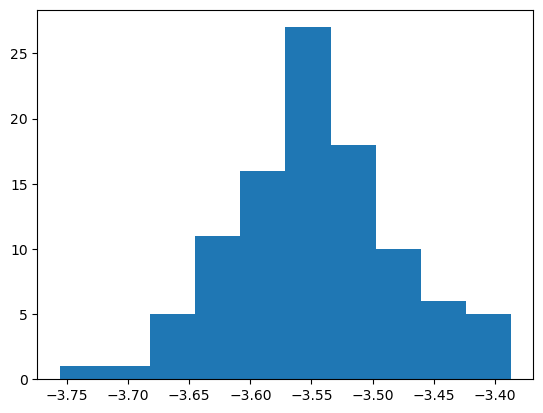

In [11]:
o = []
for i in range(100):
    o.append(model(c).log_prob(x)[0])

plt.hist(torch.stack(o).squeeze().cpu().detach().numpy())

# Training

Let's learn a bayesian flow over the classical moon example. We want to evaluate the uncertainty assigned by the flow to the density estimation in each point of the phasespace

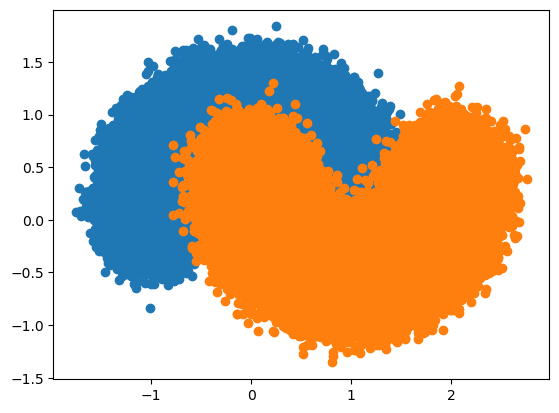

In [7]:
# Generate the two-moon dataset
Nevents = 500000
X, y = make_moons(n_samples=Nevents, noise=0.2, random_state=42)

# Separate the data points by class
X_class0 = X[y == 0]
X_class1 = X[y == 1]
plt.scatter(X_class0[:, 0], X_class0[:, 1])
plt.scatter(X_class1[:, 0], X_class1[:, 1])

In [8]:
x = torch.from_numpy(X).to(torch.float32)
c = torch.from_numpy(y).to(torch.float32).unsqueeze(-1)

In [9]:
model = zuko.flows.spline.NSF(
    features=2,
    context=1,
    bins=5,
    transforms=2,
    hidden_features=[32, 32],
    bayesian=True,
)

### Training

In [10]:
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
batch_size = 256
nepochs = 50

In [ ]:
log = []
indices = np.arange(Nevents)
for e in range(nepochs):
    np.random.shuffle(indices)
    for i in range(Nevents // batch_size):
        x_i = x[indices[i * batch_size : (i + 1) * batch_size]]
        c_i = c[indices[i * batch_size : (i + 1) * batch_size]]
        # print(x.shape)
        flow_loss = -model(c_i).log_prob(x_i).mean()
        kl_loss = zuko.utils.total_KL_divergence(model) / Nevents
        loss = flow_loss + kl_loss

        opt.zero_grad()
        loss.backward()
        opt.step()
        log.append((loss.item(), flow_loss.item(), kl_loss.item()))
        if i % 100 == 0:
            print(
                f"epoch={e}, step={i}, total loss: {loss.item():.3f}, flow loss:{flow_loss.item():.3f}, KL loss: {kl_loss.item():.3f}"
            )

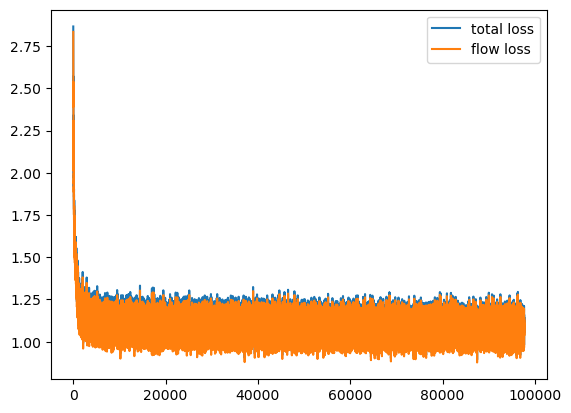

In [12]:
plt.plot([i[0] for i in log], label="total loss")
plt.plot([i[1] for i in log], label="flow loss")
plt.legend();

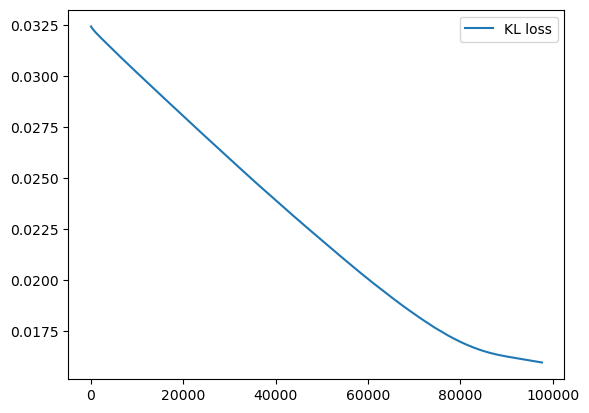

In [13]:
plt.plot([i[2] for i in log], label="KL loss")
plt.legend();

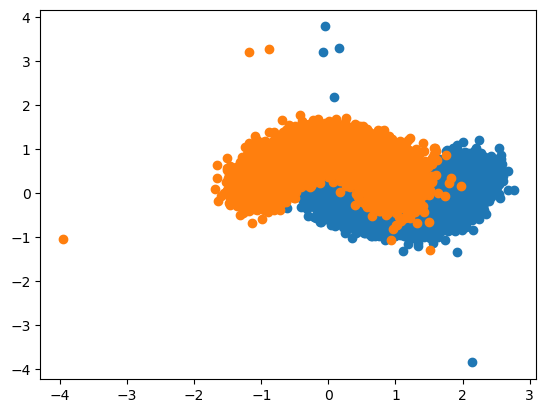

In [16]:
model.eval()
with torch.no_grad():
    samples_1 = model(torch.ones((20000, 1))).sample((1,)).cpu().squeeze().numpy()
    samples_2 = model(torch.zeros((20000, 1))).sample((1,)).cpu().squeeze().numpy()

plt.scatter(samples_1[:, 0], samples_1[:, 1])
plt.scatter(samples_2[:, 0], samples_2[:, 1])

In [21]:
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np


def profiled_histogram_2d(
    data_x,
    data_y,
    values,
    bins=10,
    range=None,
    title="2D Profiled Histogram",
    xlabel="X Bins",
    ylabel="Y Bins",
    cbar_label="Average Value",
    norm=None,
    vmax=2,
):
    # Calculate the 2D histogram with weights
    counts, x_edges, y_edges = np.histogram2d(
        data_x, data_y, bins=bins, range=range, weights=values
    )

    # Calculate the unweighted 2D histogram to handle empty bins correctly
    counts_unweighted, _, _ = np.histogram2d(data_x, data_y, bins=bins, range=range)

    # Calculate the mean value for each bin, handling empty bins
    bin_means = np.where(counts_unweighted > 0, counts / counts_unweighted, np.nan)

    # Plot the 2D profiled histogram
    # Use pcolormesh to create the 2D grid of bins with colors representing the mean values
    mesh = plt.pcolormesh(
        x_edges,
        y_edges,
        bin_means.T,  # Note the transpose (.T)
        cmap="viridis",  # You can choose a different colormap
        norm=matplotlib.colors.Normalize(vmin=np.nanmin(bin_means), vmax=vmax),
    )  # set the color scale
    plt.colorbar(mesh)

In [19]:
model.eval()

x_test = x[(c == 1).squeeze(-1)][0:100000]
c_test = torch.ones((x_test.shape[0], 1))

densities = []
with torch.no_grad():
    for i in range(100):
        densities.append(model(c_test).log_prob(x_test))

D = torch.stack(densities, dim=1)
D_mean = D.mean(dim=1)
D_std = D.exp().std(dim=1)

Average probability density over the space

/tmp/ipykernel_351638/1179208975.py:17: RuntimeWarning: invalid value encountered in divide
  bin_means = np.where(counts_unweighted > 0, counts / counts_unweighted, np.nan)


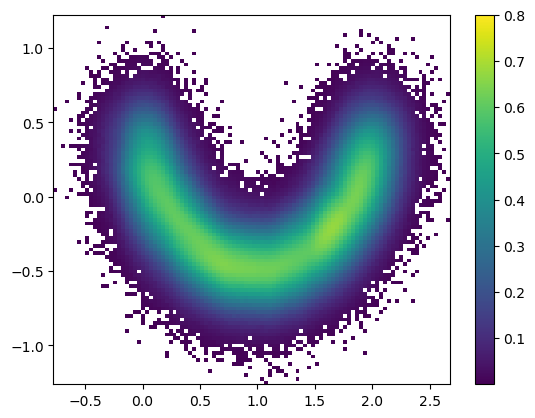

In [22]:
profiled_histogram_2d(
    x_test[:, 0].cpu().numpy(),
    x_test[:, 1].cpu().numpy(),
    D_mean.exp().cpu().numpy(),
    bins=100,
    vmax=0.8,
)

Average probability density uncertainty over the space

/tmp/ipykernel_351638/1179208975.py:17: RuntimeWarning: invalid value encountered in divide
  bin_means = np.where(counts_unweighted > 0, counts / counts_unweighted, np.nan)


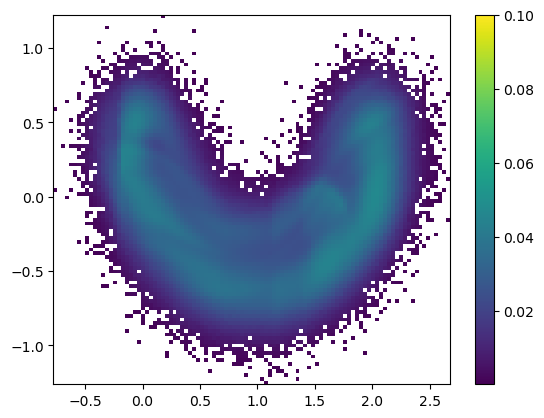

In [24]:
profiled_histogram_2d(
    x_test[:, 0].cpu().numpy(), x_test[:, 1].cpu().numpy(), D_std.cpu().numpy(), bins=100, vmax=0.1
)

Average relative uncertainty of the probability density in the phasespace

/tmp/ipykernel_351638/1179208975.py:17: RuntimeWarning: invalid value encountered in divide
  bin_means = np.where(counts_unweighted > 0, counts / counts_unweighted, np.nan)


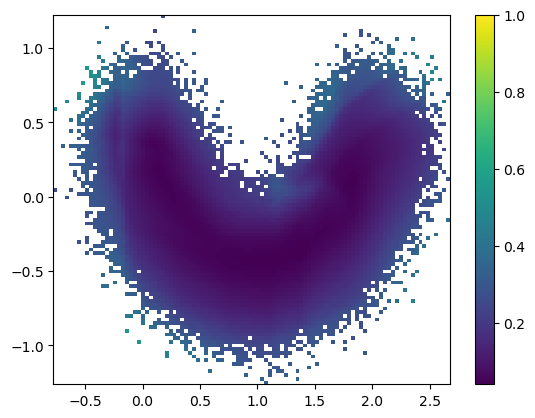

In [25]:
profiled_histogram_2d(
    x_test[:, 0].cpu().numpy(),
    x_test[:, 1].cpu().numpy(),
    D_std.cpu().numpy() / D_mean.exp().cpu().numpy(),
    bins=100,
    vmax=1,
)

# Looking at the parameters of the model

In [29]:
from zuko.nn import BayesianLinear, MaskedBayesianLinear


def get_bayesian_layers(model):
    layers = []
    masks = []
    for module in model.modules():
        if isinstance(module, MaskedBayesianLinear) or isinstance(module, BayesianLinear):
            layers.append(module)
            masks.append(module.mask)
    return layers, masks

In [30]:
blayers, masks = get_bayesian_layers(model)

In [31]:
w = []
s = []
for i in range(len(blayers)):
    w.append(blayers[0].weight[masks[0]].detach().cpu().numpy())
    s.append(blayers[0].logsig2_w.exp()[masks[0]].detach().cpu().numpy())
w = np.concatenate(w, axis=0)
s = np.concatenate(s, axis=0)

Text(0.5, 0, 'Weight distribution')

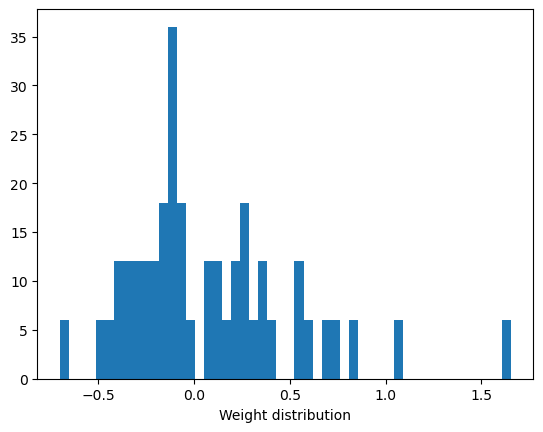

In [35]:
plt.hist(w, bins=50)
plt.xlabel("Weight distribution")

Text(0.5, 0, 'Variance of the weight distribution')

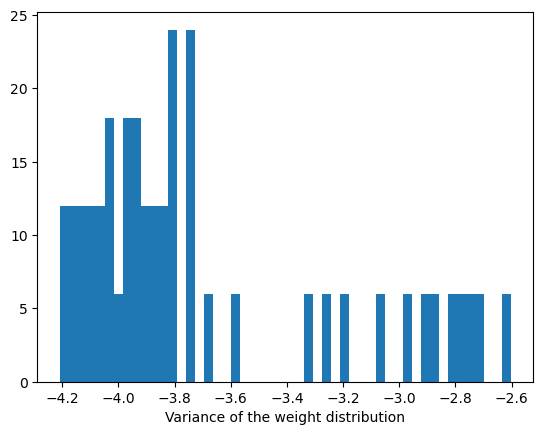

In [36]:
plt.hist(np.log10(s), bins=50)
plt.xlabel("Variance of the weight distribution")

Text(0, 0.5, 'learnt variance')

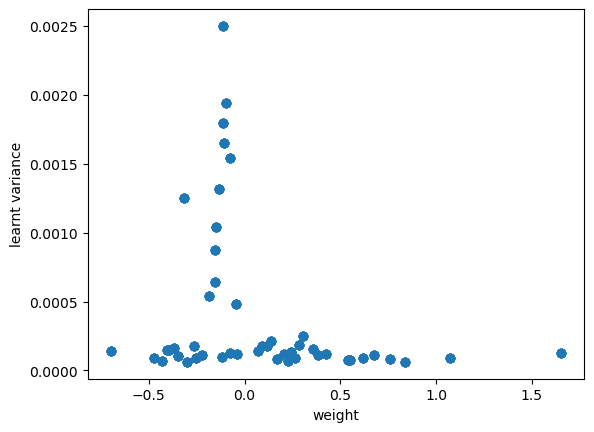

In [39]:
plt.scatter(w, s)
plt.xlabel("weight")
plt.ylabel("learnt variance")